In [1]:
import numpy as np
import numpy.ma as ma
import argparse
import sys
sys.path.append("./utils/")
import operator_calculations as op_calc
import delay_embedding as embed
import stats
import h5py
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
n_neighbors=50;min_dist=.05
f = h5py.File('../data/worm_analysis/umap_embeddings/umap_n_{:.1f}_d_{:.2f}.h5'.format(n_neighbors,min_dist),'r')
u_all = ma.masked_invalid(f['umap'])
u_all[u_all==0] = ma.masked
f.close()
u = u_all[:-1000]
centers_umap = u_all[-1000:]

In [3]:
frameRate=16.
data_dt=1/frameRate

ctraj_path = '../data/worm_analysis/ctrajs_1000_clusters/'
f = h5py.File(ctraj_path+'/c_traj_w.h5','r')
mD = f['MetaData']
n_clusters = np.array(mD['n_clusters'],dtype=int)[0]
delay = np.array(mD['delay'],dtype=int)[0]
ctraj_w = ma.array(f['ctraj_w'])
ctraj_w_mask = ma.array(f['ctraj_w_mask'])
f.close()
ctraj_w[ctraj_w_mask==1]=ma.masked

In [4]:
ctraj_all = ma.hstack(ctraj_w)

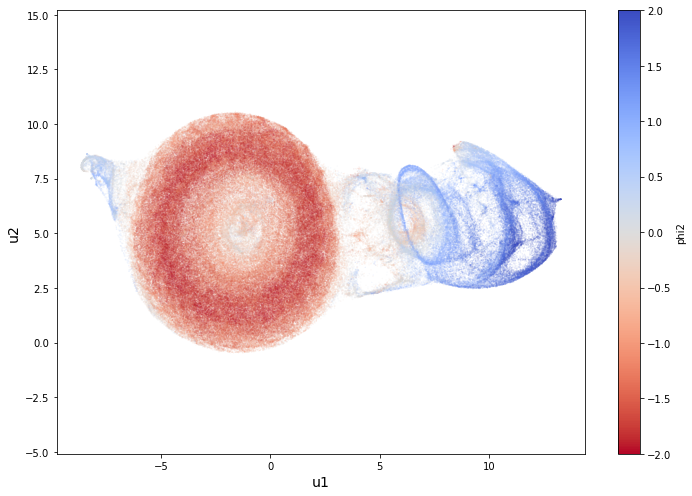

In [5]:
from matplotlib.colors import TwoSlopeNorm
vmin,vmax=-2,2
plt.figure(figsize=(10,7))
plt.scatter(u[:,0],u[:,1],s=.003,norm=TwoSlopeNorm(0,vmin=vmin,vmax=vmax),c=ctraj_all,cmap='coolwarm_r')
plt.colorbar(label = 'phi2')
plt.xlabel('u1',fontsize=14)
plt.ylabel('u2',fontsize=14)
plt.tight_layout()
plt.axis('equal')
# plt.savefig('umap_phi2_ctraj.pdf')#,dpi=500)
plt.show()

In [6]:
mat = loadmat('../data/worm_data/shapes.mat')
theta_ensemble = np.array(mat['theta_ensemble'],dtype=float)
stepper_to_mm = 788
wormCM = ma.array(mat['wormCm'][:,::2,:],dtype=float)/stepper_to_mm
wormCM[wormCM==0] = ma.masked

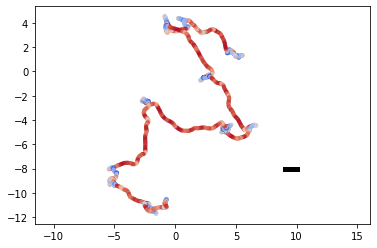

In [7]:
vmin,vmax=-2,2
len_w = len(ctraj_w[0])
kw=8
t0 = int(5*frameRate*60)
tf=int(15*frameRate*60)
plt.scatter(wormCM[kw][t0:tf,0],wormCM[kw][t0:tf,1],c=ctraj_all[kw*len_w:(kw+1)*len_w][t0:tf],s=10,alpha=.1,
            cmap='coolwarm_r',norm=TwoSlopeNorm(0,vmin=vmin,vmax=vmax))
plt.axis('equal')
plt.plot([9,10],[-8,-8],c='k',lw=5)
# plt.savefig('centroid_example_ctraj.png',dpi=500)
plt.show()

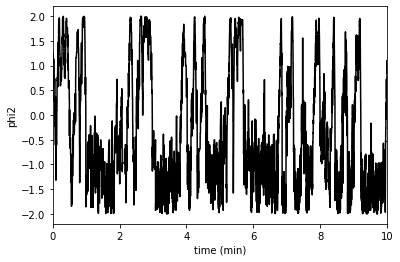

In [8]:
wsize = int(10*60*frameRate)
t0=10000
plt.plot(np.arange(wsize)*data_dt,ctraj_w[5][t0:t0+wsize],c='k')
plt.xticks(np.arange(0,wsize+1,2*60*frameRate)*data_dt,np.arange(0,11,2))
plt.xlabel('time (min)')
plt.ylabel('phi2')
plt.xlim(0,wsize*data_dt)
# plt.axis('off')
# plt.savefig('example_phi2_traj_axis.pdf')
plt.show()

In [9]:
sims_tv_w=[]
sims_w=[]
for kw in range(len(ctraj_w)):
    f = h5py.File('../data/worm_analysis/sims_fpts/sims_w_{}.h5'.format(kw),'r')
    sims = np.array(f['sims'])
    sims_tv = np.array(f['sims_tv'])
    dx = np.array(f['metaData/dx'])[0]
    h = np.array(f['metaData/h'])[0]
    overlap = np.array(f['metaData/overlap'])[0]
    step = np.array(f['metaData/step'],dtype=int)[0]
    stride = np.array(f['metaData/stride'],dtype=int)[0]
    wsize = np.array(f['metaData/wsize'],dtype=int)[0]
    f.close()
    sims_w.append(sims)
    sims_tv_w.append(sims_tv)
    print(kw)

0
1
2
3
4
5
6
7
8
9
10
11


In [10]:
def state_lifetime(states):
    durations=[]
    for state in np.sort(np.unique(states.compressed())):
        gaps = states==state
        gaps_boundaries = np.where(np.abs(np.diff(np.concatenate([[False], gaps, [False]]))))[0].reshape(-1, 2)
        durations.append(np.hstack(np.diff(gaps_boundaries)))
    return durations

In [11]:
stride = delay
step = int(0.5*delay)
dts_w=[]
for kw,X in enumerate(ctraj_w):
    labels = ma.zeros(X.shape,dtype=int)
    labels[X>0] = 1
    labels[X.mask] = ma.masked
    dts = np.array(state_lifetime(labels[::step]))*step*data_dt
    dts_w.append(dts)

<ipython-input-11-ceb6c72e5921>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dts = np.array(state_lifetime(labels[::step]))*step*data_dt


In [12]:
sims = sims_w[kw]
dts_sims=[]
for sim in sims:
    labels_sim = ma.zeros(sim.shape,dtype=int)
    labels_sim[sim>0] = 1
    dts_sim = np.array(state_lifetime(labels_sim[::step]))*step*data_dt
    dts_sims.append(dts_sim)

<ipython-input-12-093c42cff236>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dts_sim = np.array(state_lifetime(labels_sim[::step]))*step*data_dt


In [13]:
def bootstrap_rates(l,n_times,confidence_interval=95):
    per=(100-confidence_interval)/2
    new_means=[]
    for i in range(n_times):
        indices=np.random.choice(range(0,len(l)),len(l))
        new_list=[l[idx] for idx in indices]
        new_means.append(ma.mean(new_list,axis=0))
    new_means=ma.vstack(new_means)
    cil=np.zeros(new_means.shape[1])
    ciu=np.zeros(new_means.shape[1])
    for i in range(new_means.shape[1]):
        cil[i]=np.nanpercentile(1/new_means[:,i].filled(np.nan),per)
        ciu[i]=np.nanpercentile(1/new_means[:,i].filled(np.nan),100-per)
    cil = ma.masked_array(cil, np.isnan(cil))
    ciu = ma.masked_array(ciu, np.isnan(ciu))
    return 1/ma.mean(l,axis=0),cil,ciu

In [14]:
n_worms = ctraj_w.shape[0]
dts_sim_ci = np.zeros((n_worms,2,3))
dts_data_ci = np.zeros((n_worms,2,3))
for kw in range(n_worms):
    sims = sims_w[kw]
    dts_sims=[]
    for sim in sims:
        labels_sim = ma.zeros(sim.shape,dtype=int)
        labels_sim[sim>0] = 1
        dts_sim = np.array(state_lifetime(labels_sim[::step]))*step*data_dt
        dts_sims.append(dts_sim)
        
    for state_idx in range(2):
        dts_state = np.array([dts_sims[ks][state_idx].mean() for ks in range(len(sims))])
        mean= np.hstack([dts_sims[ks][state_idx] for ks in range(len(sims))]).mean()
        cil,ciu = np.percentile(dts_state,2.5),np.percentile(dts_state,97.5)
        dts_sim_ci[kw,state_idx] = [mean,cil,ciu]
        mean,cil,ciu = stats.bootstrap(dts_w[kw][state_idx],n_times=100)
        dts_data_ci[kw,state_idx] = [mean,cil,ciu]
    print(kw)

<ipython-input-14-ed9405ff0e82>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dts_sim = np.array(state_lifetime(labels_sim[::step]))*step*data_dt
<ipython-input-14-ed9405ff0e82>:19: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  dts_data_ci[kw,state_idx] = [mean,cil,ciu]


0
1
2
3
4
5
6
7
8
9
10
11


In [15]:
colors_state_=plt.rcParams['axes.prop_cycle'].by_key()['color'][:10]

In [16]:
colors_ = ['r',colors_state_[0]]

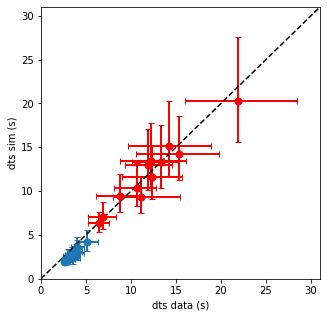

In [17]:
plt.figure(figsize=(5,5))
for state_idx in range(2):
    plt.errorbar(dts_data_ci[:,state_idx,0],dts_sim_ci[:,state_idx,0],
                 xerr = [dts_data_ci[:,state_idx,0]-dts_data_ci[:,state_idx,1],
                         dts_data_ci[:,state_idx,2]-dts_data_ci[:,state_idx,0]],
                 yerr = [dts_sim_ci[:,state_idx,0]-dts_sim_ci[:,state_idx,1],
                         dts_sim_ci[:,state_idx,2]-dts_sim_ci[:,state_idx,0]],capsize=3,ms=7,fmt='o',lw=2,c=colors_[state_idx])
xrange = np.linspace(0,31)
plt.plot(xrange,xrange,c='k',ls='--')
plt.xlim(0,31)
plt.ylim(0,31)
plt.xlabel('dts data (s)')
plt.ylabel('dts sim (s)')
# plt.savefig('predict_mean_transition_rate.pdf')
plt.show()

In [18]:
f = h5py.File('../data/worm_analysis/fpts_errorbars/fpts_errorbars.h5','r')
x_data = np.array(f['x_data'])
y_err_data = np.array(f['y_err_data'])
x_sim = np.array(f['x_sim'])
y_err_sim = np.array(f['y_err_sim'])
x_sim_Markov = np.array(f['x_sim_Markov'])
y_err_sim_Markov = np.array(f['y_err_sim_Markov'])
x_sim_tv = np.array(f['x_sim_tv'])
y_err_sim_tv = np.array(f['y_err_sim_tv'])
x_all = np.array(f['x_all'])
curvey = np.array(f['curvey'])
tscales_all = np.array(f['tscales_all'])
tscales_cil = np.array(f['tscales_cil'])
tscales_ciu = np.array(f['tscales_ciu'])
f.close()

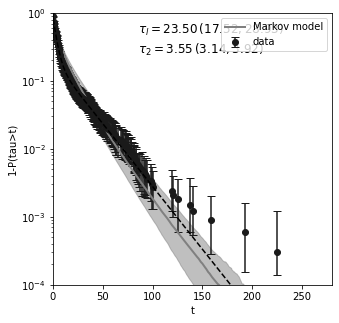

In [19]:
plt.figure(figsize=(5,5))
plt.errorbar(x_data,y_err_data[:,0],yerr = [y_err_data[:,0]-y_err_data[:,1],y_err_data[:,2]-y_err_data[:,0]],c='.1',marker='o',fmt='o',capsize=4,label='data')
plt.plot(x_all,curvey,c='k',ls='--',zorder=1000)
plt.plot(x_sim_Markov,y_err_sim_Markov[:,0],c='gray',lw=2,label='Markov model')
plt.fill_between(x_sim_Markov,y_err_sim_Markov[:,1],y_err_sim_Markov[:,2],alpha=.5,color='gray')
plt.yscale('log')
plt.text(85,.5,r'$\tau_l = {:.2f}\,({:.2f},{:.2f})$'.format(tscales_all[0],tscales_cil[0],tscales_ciu[0]),fontsize=12)
plt.text(85,.25,r'$\tau_2 = {:.2f}\,({:.2f},{:.2f})$'.format(tscales_all[1],tscales_cil[1],tscales_ciu[1]),fontsize=12)
plt.xlabel('t')
plt.legend()
plt.ylabel('1-P(tau>t)')
plt.xlim(0,280)
plt.ylim(1e-4,1)
# plt.savefig('dwell_times_pred_Markov_Model.pdf')
plt.show()

In [20]:
colors_state_=plt.rcParams['axes.prop_cycle'].by_key()['color'][:10]

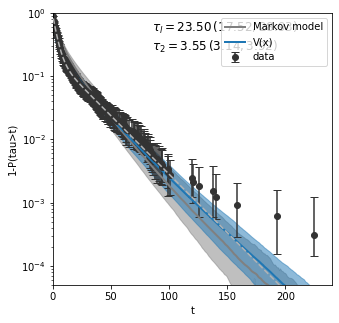

In [21]:
plt.figure(figsize=(5,5))
plt.errorbar(x_data,y_err_data[:,0],yerr = [y_err_data[:,0]-y_err_data[:,1],y_err_data[:,2]-y_err_data[:,0]],c='0.2',marker='o',fmt='o',capsize=4,label='data')
plt.plot(x_all,curvey,c='.7',ls='--',zorder=1000)
plt.plot(x_sim_Markov,y_err_sim_Markov[:,0],c='.5',lw=2,label='Markov model')
plt.fill_between(x_sim_Markov,y_err_sim_Markov[:,1],y_err_sim_Markov[:,2],alpha=.5,color='.5')
plt.plot(x_sim,y_err_sim[:,0],c=colors_state_[0],lw=2,label='V(x)')
plt.fill_between(x_sim,y_err_sim[:,1],y_err_sim[:,2],alpha=.5,color=colors_state_[0])
plt.yscale('log')
plt.text(85,.5,r'$\tau_l = {:.2f}\,({:.2f},{:.2f})$'.format(tscales_all[0],tscales_cil[0],tscales_ciu[0]),fontsize=12)
plt.text(85,.25,r'$\tau_2 = {:.2f}\,({:.2f},{:.2f})$'.format(tscales_all[1],tscales_cil[1],tscales_ciu[1]),fontsize=12)
plt.xlabel('t')
plt.legend()
plt.ylabel('1-P(tau>t)')
plt.xlim(0,240)
plt.ylim(5e-5,1)
# plt.savefig('dwell_times_pred_V_constant_vs_Markov.pdf')
plt.show()

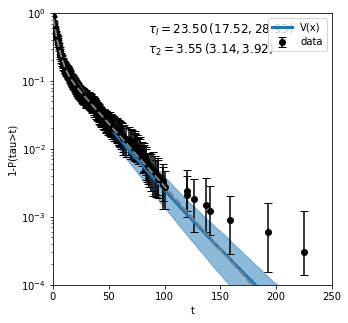

In [22]:
plt.figure(figsize=(5,5))
plt.plot(x_all,curvey,c='.5',lw=2,ls='--',zorder=1000)
plt.errorbar(x_data,y_err_data[:,0],yerr = [y_err_data[:,0]-y_err_data[:,1],y_err_data[:,2]-y_err_data[:,0]],c='k',marker='o',fmt='o',capsize=4,label='data')
plt.plot(x_sim,y_err_sim[:,0],c=colors_state_[0],lw=3,label='V(x)')
plt.fill_between(x_sim,y_err_sim[:,1],y_err_sim[:,2],alpha=.5,color=colors_state_[0])
plt.yscale('log')
plt.text(85,.5,r'$\tau_l = {:.2f}\,({:.2f},{:.2f})$'.format(tscales_all[0],tscales_cil[0],tscales_ciu[0]),fontsize=12)
plt.text(85,.25,r'$\tau_2 = {:.2f}\,({:.2f},{:.2f})$'.format(tscales_all[1],tscales_cil[1],tscales_ciu[1]),fontsize=12)
plt.xlabel('t')
plt.legend()
plt.ylabel('1-P(tau>t)')
plt.xlim(0,250)
plt.ylim(1e-4,1)
# plt.savefig('dwell_times_pred_V_constant.pdf')
plt.show()

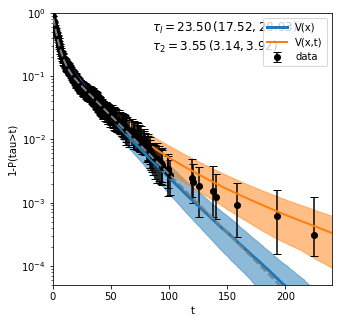

In [23]:
plt.figure(figsize=(5,5))
plt.plot(x_all,curvey,c='.5',lw=2,ls='--',zorder=1000)
plt.errorbar(x_data,y_err_data[:,0],yerr = [y_err_data[:,0]-y_err_data[:,1],y_err_data[:,2]-y_err_data[:,0]],c='k',marker='o',fmt='o',capsize=4,label='data')
plt.plot(x_sim,y_err_sim[:,0],c=colors_state_[0],lw=3,label='V(x)')
plt.fill_between(x_sim,y_err_sim[:,1],y_err_sim[:,2],alpha=.5,color=colors_state_[0])
plt.plot(x_sim_tv,y_err_sim_tv[:,0],c=colors_state_[1],lw=2,label='V(x,t)')
plt.fill_between(x_sim_tv,y_err_sim_tv[:,1],y_err_sim_tv[:,2],alpha=.5,color=colors_state_[1])
plt.yscale('log')
plt.text(85,.5,r'$\tau_l = {:.2f}\,({:.2f},{:.2f})$'.format(tscales_all[0],tscales_cil[0],tscales_ciu[0]),fontsize=12)
plt.text(85,.25,r'$\tau_2 = {:.2f}\,({:.2f},{:.2f})$'.format(tscales_all[1],tscales_cil[1],tscales_ciu[1]),fontsize=12)
plt.xlabel('t')
plt.ylabel('1-P(tau>t)')
plt.xlim(0,240)
plt.ylim(5e-5,1)
plt.legend()
# plt.savefig('dwell_times_pred_V(t).pdf')
plt.show()

# Show time varying potential landscape

In [24]:
from scipy.interpolate import UnivariateSpline

def kernel(x):
    kernel_x = ma.zeros(x.shape)
    sel = x**2<5
    kernel_x[sel] = (3/(4*np.sqrt(5)))*(1-x[sel]**2/5)
    return kernel_x

def K(h,x):
    return (1/h)*kernel(x/h)
    
def W(h,j,x,X):
    kernel_all = K(h,x-X)
    num = kernel_all[j]
    den = kernel_all.mean()
    return num/den

def fit_sde_errorbars(x,X,stride,data_dt,h):
    tau=stride*data_dt
    X_lag = ma.vstack([X[:-stride],X[stride:]]).T
    sel = ~np.any(X_lag.mask,axis=1)
    indices = np.arange(X[:-stride].shape[0])[sel]
    N = sel.sum()
    #W function
    kernel_all = K(h,x-X)
    kernel_mean = kernel_all.mean()
    terms = D1_D2_parallel(indices,kernel_all,kernel_mean,X,stride)
    D1_mean,D2_mean = np.mean(terms,axis=0)
    D1 = D1_mean/tau
    D2 = D2_mean/(2*tau)
    D1_std,D2_std = np.std(terms,axis=0)
    D1_err = D1_std/tau/np.sqrt(len(terms))
    D2_err = D2_std/(2*tau)/np.sqrt(len(terms))
    return D1,D1_err,D2,D2_err

from numba import jit,prange
@jit(nopython=True,parallel=True)
def D1_D2_parallel(indices,kernel_all,kernel_mean,X,stride):
    terms = np.zeros((len(indices),2))
    for kj in prange(len(indices)):
        j = indices[kj]
        t1 = (kernel_all[j]/kernel_mean)*(X[j+stride]-X[j])
        t2 = (kernel_all[j]/kernel_mean)*(X[j+stride]-X[j])**2
        terms[kj] = [t1,t2]
    return terms

def fit_stochastic_model_kernel(X,centers_kernel,stride,data_dt,h):
    f_kernel = np.zeros(len(centers_kernel))
    a_kernel = np.zeros(len(centers_kernel))
    f_err_kernel = np.zeros(len(centers_kernel))
    a_err_kernel = np.zeros(len(centers_kernel))
    for kc,x in enumerate(centers_kernel):
        D1,D1_err,D2,D2_err = fit_sde_errorbars(x,X,stride,data_dt,h)
        f_kernel[kc] = D1
        a_kernel[kc] = D2
        f_err_kernel[kc] = D1_err
        a_err_kernel[kc] = D2_err 
    return f_kernel,a_kernel,f_err_kernel,a_err_kernel

In [25]:
X = ctraj_w[2]

wsize = int(10*60*frameRate)

edges_kernel = np.arange(X.min(), X.max(), dx)
centers_kernel = 0.5*(edges_kernel[1:]+edges_kernel[:-1])

wstarts = np.arange(0,len(X)-wsize,int(wsize*overlap))
spl_f_kernel_t = []
spl_a_kernel_t = []
indices=[]
for kt,t0 in enumerate(wstarts):
    if ma.count_masked(X[t0:t0+wsize])<0.5*wsize:
        indices.append(kt)
        f_kernel,a_kernel,f_err_kernel,a_err_kernel = fit_stochastic_model_kernel(X[t0:t0+wsize],centers_kernel,stride,data_dt,h)
        sel = ~np.logical_or(np.isnan(f_kernel),f_kernel==0)
        spl_f_ = UnivariateSpline(centers_kernel[sel],f_kernel[sel], w=1/f_err_kernel[sel],k=1,s=0,ext='zeros')
        spl_a_ = UnivariateSpline(centers_kernel[sel],a_kernel[sel], w=1/a_err_kernel[sel],k=1,s=0,ext='zeros')
        spl_f_kernel_t.append(spl_f_)
        spl_a_kernel_t.append(spl_a_)
twindows = (wstarts[indices]+wsize/2)*data_dt

In [26]:
xrange = np.linspace(-2,2,50)
colors_t = plt.cm.viridis(np.linspace(0,1,len(wstarts)))
V_t = ma.zeros((len(twindows),len(xrange)))
for kt in range(len(twindows)):
    D1 = spl_f_kernel_t[kt](xrange)
    D2 = spl_a_kernel_t[kt](xrange)
    sel = np.logical_and(np.abs(D1)>0,np.abs(D2)>0)
    barrier_idx = np.argmin(np.abs(xrange[sel]))+1
    
    dD2_dx = np.gradient(D2[sel],xrange[sel])
    V = -np.cumsum((D1[sel]-dD2_dx)/D2[sel]*dx)
    V = V-V[barrier_idx]
    V_t[kt,sel] = V
    V_t[kt,~sel] = ma.masked

In [27]:
colors_t = plt.cm.viridis(np.linspace(0,1,len(twindows)))

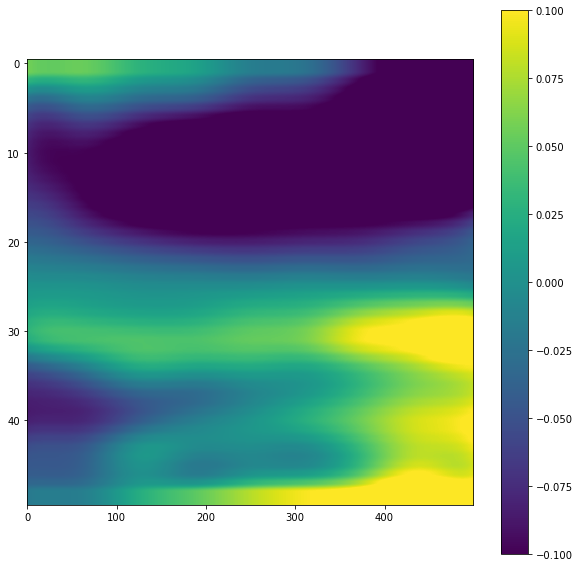

In [28]:
#interpolate the potentials over time
from scipy.interpolate import RectBivariateSpline
plt.figure(figsize=(10,10))
sel = ~np.any(V_t.mask,axis=0)
func = RectBivariateSpline(twindows, xrange[sel], V_t[:,sel], s=.1)
tnew = np.linspace(twindows[0],twindows[-1],500)
znew = func(tnew,xrange)
plt.imshow(znew.T,aspect=10,vmax=.1,vmin=-.1)
plt.colorbar()
plt.show()

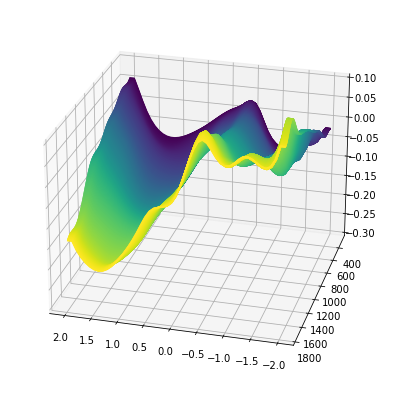

In [29]:
from mpl_toolkits import mplot3d
colors_t = plt.cm.viridis(np.linspace(0,1,znew.shape[0]))

ax = plt.figure(figsize=(7,7)).add_subplot(projection='3d')
ax.view_init(25, 105)

for kt in range(len(znew)):
    ax.plot(-xrange,tnew[kt]*np.ones(len(xrange)), znew[kt],c=colors_t[kt])
ax.set_zlim(-.3,.1)
# plt.savefig('time_varying_potential_axis.pdf')
plt.show()